<a href="https://colab.research.google.com/github/anvichip/lung_cancer_classification/blob/main/lung_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import zipfile
import random
import shutil
import numpy as np
from shutil import copyfile

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras 
from google.colab import files
from keras.preprocessing import image
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
!unzip data_lung.zip 

Archive:  data_lung.zip
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (1).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (10).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (100).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (101).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (102).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (103).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (104).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (105).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (106).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (107).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (108).jpg  
  inflating: The IQ-OTHNCCD lung cancer data

In [ ]:
#cd data

/content/data


In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
splitfolders.ratio('/content/data',output = 'split_data', seed = 1337, ratio = (0.8,0.1,0.1))

ValueError: ignored

In [ ]:
dataset_train_dir = '/content/split_data/train'
dataset_test_dir = '/content/split_data/val'

### **Size of folders**

In [ ]:
print(len(os.listdir('/content/split_data/train/Bengin cases')) + len(os.listdir('/content/split_data/train/Malignant cases')) + len(os.listdir('/content/split_data/train/Normal cases')))
print(len(os.listdir('/content/split_data/val/Bengin cases')) + len(os.listdir('/content/split_data/val/Malignant cases')) + len(os.listdir('/content/split_data/val/Normal cases')))


876
109


### **AUGMENTATION**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2, #0.2, 0.5
    height_shift_range=0.2, #0.2, 0.5
    shear_range=0.2,
    zoom_range=[0.5, 1.0], # 0.2, 0.5, [0.5,1.0]
    rotation_range=40, #20, 40, 60, 90
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect' #nearest, reflect, wrap
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2, #0.2, 0.5
    height_shift_range=0.2, #0.2, 0.5
    shear_range=0.2,
    zoom_range=[0.5, 1.0], # 0.2, 0.5, [0.5,1.0]
    rotation_range=40, #20, 40, 60, 90
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect' #nearest, reflect, wrap
)

### **PREVIEW AUGMENTATION**

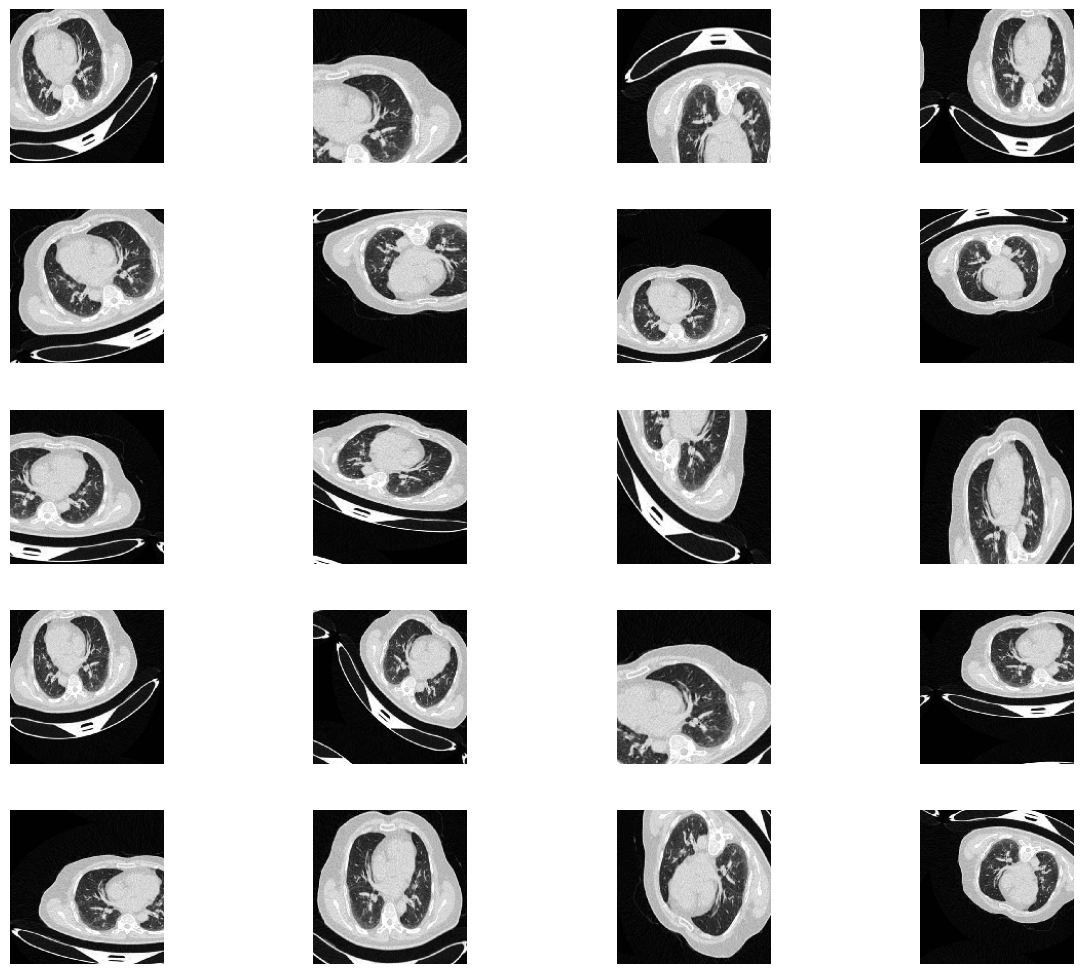

In [ ]:
from PIL import Image
path_aug = "/content/split_data/train/Bengin cases/Bengin case (1).jpg"
img_augmentation = load_img(path_aug)
x_aug = tf.keras.utils.img_to_array(img_augmentation)
#x_aug = image.img_to_array(img_augmentation)
x_aug = x_aug.reshape((1,) + x_aug.shape)

i = 0
for batch in train_datagen.flow(x_aug, batch_size=1, save_to_dir='/content/preview', save_prefix='fruit', save_format='jpeg'):
    i += 1
    if i >= 20:
        break

preview_img = os.listdir('/content/preview')

plt.figure(figsize=(15, 15))
for n in range(len(preview_img)):
  plt.subplot((int)(len(preview_img)/4)+1, 4, n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(load_img(os.path.join('/content/preview', preview_img[n]),
                            color_mode="rgb",
                            target_size=(150, 150),
                            interpolation="nearest"))
  plt.axis('off')
plt.show()

for fn in preview_img:
  os.system(f'rm {os.path.join("/content/preview", fn)}')

### **Image Data Generator**

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/split_data/train',
                                                    batch_size=32,
                                                    color_mode="grayscale",
                                                    # shuffle = False,
                                                    target_size=(150,150),
                                                    class_mode='categorical',
                                                    classes=['Bengin cases', 'Malignant cases', 'Normal cases'])

validation_generator = train_datagen.flow_from_directory('/content/split_data/val',
                                                         batch_size=32,
                                                         color_mode="grayscale",
                                                         # shuffle = False,
                                                         target_size=(150,150),
                                                         class_mode='categorical',
                                                         classes=['Bengin cases', 'Malignant cases', 'Normal cases'])

Found 876 images belonging to 3 classes.
Found 109 images belonging to 3 classes.


In [ ]:
dataset_train_dir = '/content/split_data/train'
dataset_test_dir = '/content/split_data/val'

In [ ]:
#if you want to use tranfer learning, skip this cell
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 36, 36, 64)       

In [ ]:
train_len = 0
for foldername in os.listdir('/content/split_data/train'):
    train_len = train_len + len(os.listdir(os.path.join('/content/split_data/train',foldername)))
    
val_len = 0
for foldername in os.listdir('/content/split_data/val'):
    val_len = val_len + len(os.listdir(os.path.join('/content/split_data/val',foldername)))

print(train_len)
print(val_len)

876
109


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=(train_len/32),
    epochs=10,
    verbose=1,
    #callbacks=[callbacks],
    validation_data=validation_generator,
    validation_steps=(val_len/32))

Epoch 1/10
27/27 [==============================] - 56s 2s/step - loss: 2.5499 - accuracy: 0.4886 - val_loss: 0.9777 - val_accuracy: 0.5321
Epoch 2/10
27/27 [==============================] - 56s 2s/step - loss: 1.0042 - accuracy: 0.4715 - val_loss: 1.0498 - val_accuracy: 0.5138
Epoch 3/10
27/27 [==============================] - 55s 2s/step - loss: 0.9833 - accuracy: 0.5114 - val_loss: 0.9779 - val_accuracy: 0.5138
Epoch 4/10
27/27 [==============================] - 55s 2s/step - loss: 0.9754 - accuracy: 0.5103 - val_loss: 0.9597 - val_accuracy: 0.5138
Epoch 5/10
27/27 [==============================] - 60s 2s/step - loss: 0.9559 - accuracy: 0.5114 - val_loss: 0.9499 - val_accuracy: 0.5138
Epoch 6/10
27/27 [==============================] - 59s 2s/step - loss: 0.9454 - accuracy: 0.5114 - val_loss: 0.9547 - val_accuracy: 0.5138
Epoch 7/10
27/27 [==============================] - 62s 2s/step - loss: 0.9324 - accuracy: 0.5240 - val_loss: 0.9349 - val_accuracy: 0.5505
Epoch 8/10
27/27 [==

<Figure size 640x480 with 0 Axes>

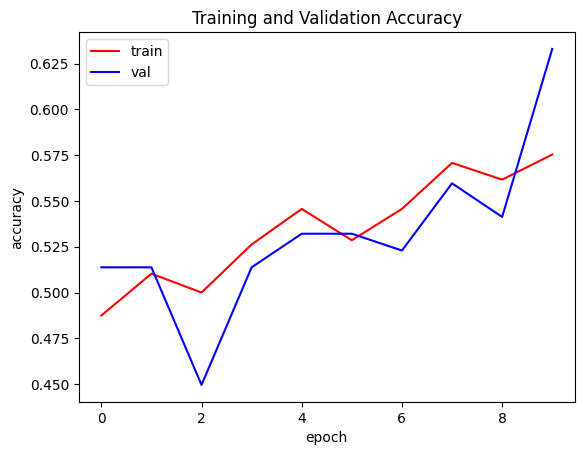

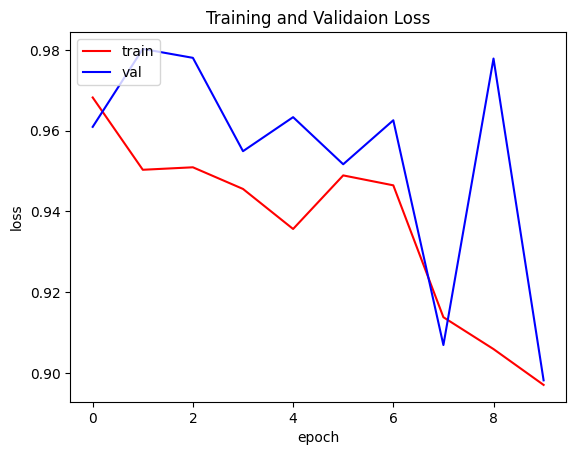

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.figure()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(150, 150),
                                                  shuffle = False,
                                                  class_mode='binary')

filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = model.evaluate(test_generator,steps = (nb_samples), verbose=1)
print('accuracy test: ',acc)
print('loss test: ',loss)

In [ ]:
model.save('model_epoch.h5')

In [ ]:
from tensorflow.keras.applications import Xception, VGG16, InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import pandas as pd

####################### init pre_trained_model #################################

# pre_trained_model = InceptionV3(input_shape=(150,150,3),
#                                 include_top=False)

pre_trained_model = VGG16(input_shape=(150,150,3),
                          include_top=False)

# pre_trained_model = Xception(input_shape=(150,150,3),
#                              include_top=False)

# pre_trained_model.layers.pop()

####################### init pre_trained_model #################################

############################## freeze layer ####################################

for layer in pre_trained_model.layers:
    layer.trainable = False

# for layer in pre_trained_model.layers[:-4]:
#     layer.trainable = False

############################## freeze layer ####################################

############################## Flatten Layer ###################################

# last_output = pre_trained_model.layers[-1].output
# x = layers.Flatten()(last_output)

x = layers.Flatten()(pre_trained_model.output)

############################## Flatten Layer ###################################

######################### Fully Connected Layer ################################

x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

######################### Fully Connected Layer ################################

model = Model(pre_trained_model.input, x) 
model.compile(optimizer='adam', #RMSprop(lr=0.0001), adam
              loss='binary_crossentropy',
              metrics=['accuracy'])

pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in pre_trained_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

58889256/58889256 [==============================] - 1s 0us/step


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f332d972df0>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f332db13a30>,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f332d905370>,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f332d995eb0>,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f332d9952b0>,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f332e054a00>,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f332cf2fb20>,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f332d995850>,block3_conv1,False
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f332cf2f130>,block3_conv2,False
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f332d9950d0>,block3_conv3,False


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=(train_len/32),
    epochs=3,
    verbose=1,
    #callbacks=[callbacks],
    validation_data=validation_generator,
    validation_steps=(val_len/32)
)

NameError: ignored